In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/legal_text_classification.csv")

In [3]:
df.head(5)

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


<Axes: xlabel='case_outcome', ylabel='count'>

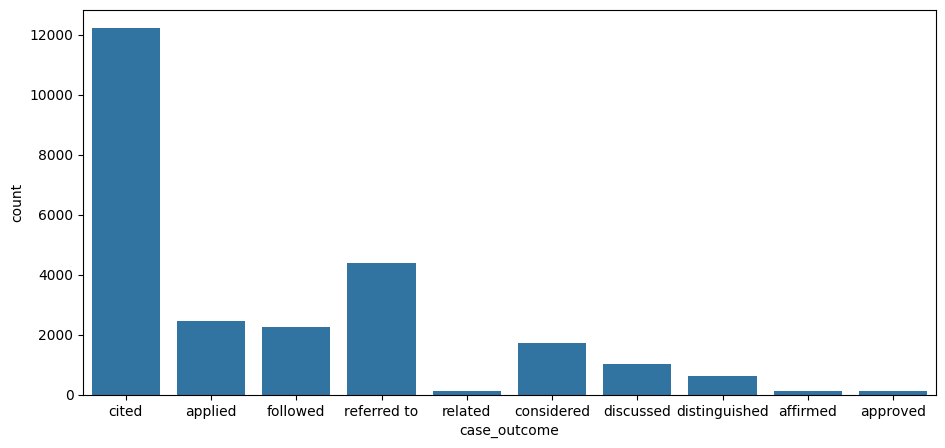

In [4]:
plt.figure(figsize = (11, 5))
sns.countplot(x='case_outcome', data=df)

In [5]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments faiss-cpu

In [15]:
import pandas as pd
import re
import numpy as np
import google.generativeai as genai
from sentence_transformers import SentenceTransformer
import faiss

# Clean and combine text
df['case_title'] = df['case_title'].str.strip()
df['case_text'] = df['case_text'].str.strip()

def generate_prompt(row):
    title = row['case_title']
    text = row['case_text']
    return f"""Case Title: {title}

Case Description: {text}

Give a detailed legal verdict including:
- Legal reasoning
- Verdict (Guilty/Not Guilty/Settled/etc.)
- Punishment (if any)
- Relief or Compensation."""

df['prompt'] = df.apply(generate_prompt, axis=1)

# Clean the prompts
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\[\d+\]', '', text)
    return text.strip()

df['prompt'] = df['prompt'].apply(clean_text)

# If 'verdict' column doesn't exist, create a placeholder
if 'verdict' not in df.columns:
    df['verdict'] = [""] * len(df)

# Save cleaned dataset
df.to_csv("preprocessed_ai_lawyer_dataset.csv", index=False)

In [18]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['prompt'].tolist(), show_progress_bar=True)

# FAISS indexing
embedding_dim = embeddings.shape[1]
index = faiss.IndexFlatL2(embedding_dim)
index.add(np.array(embeddings))

# Gemini setup
GOOGLE_API_KEY = "************************************"  # ⚠️ Store this securely!
genai.configure(api_key=GOOGLE_API_KEY)
gemini_model = genai.GenerativeModel("gemini-2.0-flash")

# Similar case retrieval
def find_similar_cases(new_prompt, k=3):
    new_vec = model.encode([new_prompt])
    D, I = index.search(np.array(new_vec), k)
    similar_prompts = df.iloc[I[0]]['prompt'].tolist()
    similar_verdicts = df.iloc[I[0]]['verdict'].tolist()
    return list(zip(similar_prompts, similar_verdicts))

# Construct full prompt
def construct_contextual_prompt(new_case_prompt):
    similar_cases = find_similar_cases(new_case_prompt)
    context = ""
    for i, (p, v) in enumerate(similar_cases):
        context += f"\n=== Past Case {i+1} ===\nPrompt:\n{p}\nVerdict:\n{v}\n"
    full_prompt = f"""{context}

New Case:
{new_case_prompt}

Give a detailed legal verdict for this new case using legal reasoning, precedent, and similar outcomes."""
    return full_prompt

# Generate verdict
def get_verdict(new_case_prompt):
    prompt = construct_contextual_prompt(new_case_prompt)
    response = gemini_model.generate_content(prompt)
    return response.text

Batches:   0%|          | 0/781 [00:00<?, ?it/s]

In [20]:
new_case = """Case Title: your title
Case Description: description of the title"""

verdict = get_verdict(new_case)
print(verdict)

Okay, let's break down the Waqf Amendment Act case and craft a legal verdict.

**Understanding the Case**

The core issue is the Waqf Amendment Act's provisions, which:

1.  **Permit Non-Muslims in Waqf Administration:**  Traditionally, waqfs (religious endowments in Islamic law) are managed by Muslims. This change allows for non-Muslim participation in administrative bodies.
2.  **Grant State Power of Determination:** The state is empowered to decide whether a property is a waqf or government property.  This potentially allows the state to reclassify properties previously considered waqfs.

**Legal Reasoning**

To construct a verdict, we need to consider several key legal principles and potential challenges:

1.  **Religious Freedom and Minority Rights:** International law (and many national constitutions) protect freedom of religion and the rights of religious minorities. However, these rights are not absolute and can be subject to limitations that are "prescribed by law" and "necess